In [1]:
# TO-DO

# 1 Double check algorithms!
# 2 Double check index value calculators! (DB-index especially!!)
# 3 SCALE INPUT VARIABLES ??


# 3 TROUBLESHOOT ERRORS! XX
# 4 CENTROID CALCULATOR FUNCTION FOR MST XX

In [6]:
# Import some modules which we will use later

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
from python_algorithms.basic.union_find import UF

%matplotlib inline

## Functions

In [7]:
# Define custom function

## Basic functions for all algorithms

def euclidean_dist(x,y):
    """Calculates Euclidean distance between 2 n-dimensional vectors"""
    temp = x-y
    temp_2 = temp**2
    temp_sum = sum(temp_2)
    temp_sqrt = math.sqrt(temp_sum)
    
    return temp_sqrt

def benchmark_data_generation(n,p,K,std):
    """Generates benchmak data for clustering"""

    from sklearn.datasets.samples_generator import make_blobs
    X, y = make_blobs(n_samples=n, centers=K, n_features = p,
                  random_state=0, cluster_std=std)
    
    return X, y

## Functions for the MST algorithm

def adjacency_matrix(X):
    """Calculates distance matrix of input data points"""
    n = X.shape[0]
    X = np.array(X)
    dist_matrix = np.zeros((n, n))
    for i in range(0,n):
        for j in range(i+1,n):
            dist_matrix[i,j]= np.linalg.norm(X[i]-X[j])
            
    return dist_matrix

def adjacency_matrix1(X):
    """Calculates distance matrix of input data points"""
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(0,n):
        for j in range(i+1,n):
            dist_matrix[i,j]=euclidean_dist(np.array(X.iloc[i,]),np.array(X.iloc[j,]))
            
    return dist_matrix

def edge_vector(dist_matrix):
    """Creates list of edges/vertices with the corresponding distance"""
    n=len(dist_matrix)
    n_rows = int(n*(n-1)*(0.5))
    edge_dist = np.zeros((n_rows, 3))
    
    counter = 0
    
    for i in range(0,n):
        for j in range(i+1,n):
            
            edge_dist[counter,0] = i
            edge_dist[counter,1] = j
            edge_dist[counter,2] = dist_matrix[i,j]
            counter += 1
            
    return edge_dist

def edge_sorting(edge_vector):
    """Sorts the list of edges/distances"""
    sorted_matrix = edge_vector[edge_vector[:, -1].argsort(kind='mergesort')]
    
    return sorted_matrix


## Functions for MST/Kruskal algorithm
def mst_cluster_UF(X, k):
    """Kruskal algorithm for MST"""
    X = pd.DataFrame(X)
    #tree = python_algorithms.basic.union_find.UF(len(X))
    tree = UF(len(X))
    #print("Shape of X: {}".format(X.shape))
    matrix = adjacency_matrix(X)
    vector = edge_vector(matrix)
    sorted_vector = edge_sorting(vector)
    i = 0
    while tree.count() > k:
        #get nodes
        node1 = sorted_vector[i][0].astype('int')
        node2 = sorted_vector[i][1].astype('int')
        # find tree of each node
        tree1 = tree.find(node1)
        tree2 = tree.find(node2)
        i = i + 1
        # connect them if in different trees
        if tree1 != tree2:
            tree.union(node1, node2)
    temp =  np.ones((len(X),2), dtype=int)
    for point in range(len(X)):
        temp[point][0] = int(point)
        temp[point][1] = int(tree.find(point))
    return temp


def mst_cluster(X, k, d):
    X = pd.DataFrame(X)
    #print("Shape of X: {}".format(X.shape))
    matrix = adjacency_matrix(X)
    vector = edge_vector(matrix)
    sorted_vector = edge_sorting(vector)
    #print("Shape of sorted_vector: {}".format(sorted_vector.shape))


    i = 0
    #initialize 1 cluster for each point
    points_set = X.join(pd.DataFrame(np.arange(0,len(X)), columns=['Cluster']))
    #print("Shape of point_set: {}".format(points_set.shape))
    #set stopping point
    while points_set['Cluster'].nunique() > k:
        #start from firs row or sorted vector, get nodes
        node1 = sorted_vector[i][0].astype('int')
        node2 = sorted_vector[i][1].astype('int')
        #identify to which cluster each point belongs
        cluster1 = points_set.iloc[node1,d]
        cluster2 = points_set.iloc[node2,d]
        #cluster1 = points_set.iloc[node1,2]
        #cluster2 = points_set.iloc[node2,2]
        #if they are from the same cluster already, no connection can be made to avoid cycle
        if cluster1 != cluster2:
            # if they are different, the smaller cluster label will be given to the larger
            if cluster1 < cluster2:
                #points_set.iloc[node2,2] = cluster1
                points_set.iloc[node2,d] = cluster1
            else:
                #points_set.iloc[node1,2] = cluster2
                points_set.iloc[node1,d] = cluster2
        i = i +1
        
    #points_set.drop(columns=[0,1])
    col_list = list(np.arange(0,d,1))
    #print(col_list)
    points_set.drop(columns=col_list)
    points_set['point_index'] = points_set.index
    points_set = points_set[['point_index', 'Cluster']]
    points_set = np.array(points_set)
    return points_set


def centroid_calc_for_mst(K,d,result,X):
    """Calculates the centroids of the clusters
    found by the MST method"""
    
    # Get current unique labels
    uniques = pd.DataFrame(result).iloc[:,1]
    uniques = uniques.unique()
    
    # Loop over the clusters table and assign cluster names
    # going from 0-15 (basically just renaming clusters for convenience)
    for i in range(0,len(result)):
        # Getting the current cluster label
        index = int(result[i,1]) 
        # Searching the current cluster label in the list of unique labels
        unique_places = np.array([i==index for i in uniques])

        # Assign the relative location of the current label to the range of 0-15
        temp = np.where(unique_places)[0]
        result[i,1] = temp

    # Initialize the centroids to be 0
    centroids2 = np.zeros((K, d))

    for i in range(0,K):
                # Filter for points in the given cluster
                temp_table2 = result[result[:,1]==i]

                # Calculating new centroids
                temp_array = np.zeros((len(temp_table2),d))
                counter = 0
                


                for j in temp_table2[:,0]:
 
                    temp_array[counter,:] = X[j,:]
                    counter += 1

                # Assign the new centroids - coordinate-wise mean of points in the cluster
                centroids2[i,:] = np.mean(temp_array, axis=0)

    return centroids2

## Functions for the k-means algorithms

def k_means_clustering(K,X):
    n = X.shape[0] # Number of observations
    d = X.shape[1] # dimensions
    X = np.array(X) # Convert pandas dataframe to numpy array

    # STEP 0
    # Get initial starting points from the ddata points
    initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
    print(initial_indices)
    
    # Initialize centroids
    centroids = np.zeros((K, d))

    counter = 0
    
    # Get initial centroids as the randomly chosen datapoints
    for i in initial_indices:
        centroids[counter,:] = X[i,:]
        counter += 1


    # STEP 1
    # Initialize table for holding the datapoint indexes and
    # their corresponding clusters
    cluster_table = np.zeros((n, 2))
    cluster_table[:,0] = np.arange(0,n,1)
    cluster_table = cluster_table.astype(int)
    
    
    change_tracker = True
    
    cost_values_db = [] # Initialize list for DB-index values during iterations
    cost_values_dunn = [] # Initialize list for Dunn-index values during iterations

    while change_tracker: #
        
        # Initialize counter for the changes in cluster assignments
        overall_change = 0
        
        # Loop over data points
        for i in range(0,n):
            current_cluster = int(cluster_table[i,1])
            #print(current_cluster)
            #current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
            
            # Calculate distance for a point from its current cluster centroid
            current_dist = np.linalg.norm(X[i,]-centroids[current_cluster,])
            
            # Loop over clusters
            for j in range(0,K):
                #temp = euclidean_dist(X[i,],centroids[j,])
                
                # Calculate distance for a point and all potential cluster centroids
                temp = np.linalg.norm(X[i,]-centroids[j,])
                
                # Assign a point to the closest cluster
                if temp<current_dist:
                    cluster_table[i,1]=j
                    current_dist = temp
                    
                    # If a point changes cluster in the iteration, increment the counter
                    overall_change += 1
        
        # If no point changes cluster in a given iteration, the stopping criteria is met
        if overall_change == 0:
            change_tracker = False

        # STEP 2
        # Recalculate centroids

        # Filter observations for a 
        #temp_table = cluster_table[cluster_table[:,1]==0]
        #print(temp_table)
        
        # Loop over clusters
        for i in range(0,K):
            
            # Filter for points in the given cluster
            temp_table2 = cluster_table[cluster_table[:,1]==i]

            # Initialize temporary table for points in the given cluster
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0
            
            # Put the values of points into the temporary table
            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Calculate cluster centroids as average of points in the cluster
            if len(temp_array)>0:
                centroids[i,:] = np.mean(temp_array, axis=0)
                
        # Append index values from the current iteration to the list
        cost_values_db.append(DB_index(X,centroids,cluster_table))
        cost_values_dunn.append(dunn_index(X,centroids,cluster_table))
            
    return centroids,cluster_table,cost_values_db,cost_values_dunn

## Functions for the Davies-Boulding-index

# Within cluster distances
def within_cluster_dist(X,centroids,cluster_table):
    """Calculates distance for points from their index"""
    
    # Initialize list for the cluster sums
    sums = []
    
    # Loop over clusters
    for i in range(0,len(centroids)):
        
        # Filter for datapoints in the given cluster
        temp = cluster_table[cluster_table[:,1]==i]
        temp_sum = 0
        
        # Calculate distance between point and its corresponding cluster
        # Sum them for a given cluster
        if len(temp)!=0:
            for j in range(0,len(temp)):
                index = int(temp[j,0])
                #current_dist = euclidean_dist(X[index,],centroids[i,])
                #current_dist = euclidean_dist(X[index,:],centroids[i,:])
                current_dist = np.linalg.norm(X[index,:]-centroids[i,:])
                temp_sum += current_dist

            temp_sum = math.sqrt(temp_sum/len(temp))
        
        # Add current value to the list
        sums.append(temp_sum)
        
    return sums

# Cluster separation
def cluster_separation(centroids):
    """Calculates cluster separation metrics based on the centroids"""
    
    # Get combinations of clusters
    combinations = int(len(centroids)*(len(centroids)-1)/2)
    #print(combinations)
    separations = np.zeros((combinations,3))
    #print(separations)

    counter = 0
    
    # Loop over cluster combinations
    # Calculate distance between their centroids
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j
            #separations[counter,2] = euclidean_dist(centroids[i,],centroids[j,])
            separations[counter,2] = np.linalg.norm(centroids[i,]-centroids[j,])
            
            counter += 1
            
    return separations

# Calculates Davies-Bouldien index
def DB_index(X,centroids,cluster_table):
    """Calculates Davies-Bouldien index for the clustering"""
    
    # Calculates within cluster distances
    sums = within_cluster_dist(X,centroids,cluster_table)
    
    # Calculates cluster centroid distances
    separations = cluster_separation(centroids)

    # Calculate intermediary metric
    r_s = separations.copy()
    for i in range(0, len(r_s)):
        index_1 = int(r_s[i,0])
        index_2 = int(r_s[i,1])
        r_s[i,2] = (sums[index_1]+sums[index_2])/separations[i,2]

    d = []
    
    # Loop over clusters
    for j in range(0,len(centroids)):
        
        # Calculate DB-index values for the clusters
        if j==0:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            d.append(max1)
        elif j==len(centroids)-1:
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            d.append(max2)
        else:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            final_max = max(max1,max2)
            d.append(final_max)
    
    # Average DB index values across clusters
    DB_index_val = sum(d)/len(centroids)
    
    return DB_index_val


## Functions for the Dunn-index
def max_within_distances(X,centroids,cluster_table):
    """Calculates maximum distance between any 2 points in the same cluster"""
    
    # Initialize list for holding result for each cluster
    max_within_distances = []
    
    # Loop over clusters
    for k in range(0,len(centroids)):
        
        # Filter for points inside the given cluster
        temp_table = cluster_table[cluster_table[:,1]==k]
        temp_max = 0
        
        # Loop over points in the given cluster
        for i in range(0,len(temp_table)):
            for j in range(i+1,len(temp_table)):
                index_1 = temp_table[i,0]
                index_2 = temp_table[j,0]
                #current_value = euclidean_dist(X[index_1,],X[index_2,])
                current_value = np.linalg.norm(X[index_1,]-X[index_2,])
                
                # Get the maximum among all
                if current_value>temp_max:
                    temp_max = current_value
        
        # Append to the lists of results
        max_within_distances.append(temp_max)
        
    return max_within_distances


def min_between_distances(X,centroids,cluster_table):
    """Calculates minimum distance between any 2 point in different clusters"""
    
    # Get combination of clusters
    combinations = int(len(centroids)*(len(centroids)-1)/2)
    
    # Initialize separation metric
    separations = np.zeros((combinations,3))

    counter = 0
    
    # Loop over cluster combination
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j

            temp_table1 = cluster_table[cluster_table[:,1]==i]
            temp_table2 = cluster_table[cluster_table[:,1]==j]
            
            # Calculate distances between all points in different clusters
        
            if len(temp_table1)>0 and len(temp_table2)>0:
                index_1 = temp_table1[0,0]
                index_2 = temp_table2[0,0]
                #temp_min = euclidean_dist(X[index_1,],X[index_2,])
                temp_min = np.linalg.norm(X[index_1,]-X[index_2,])
            else:
                temp_min = 1000
                
            for l in range(0,len(temp_table1)):
                for h in range(0,len(temp_table2)):
                    index_1 = temp_table1[l,0]
                    index_2 = temp_table2[h,0]
                    #current_value = euclidean_dist(X[index_1,],X[index_2,])
                    current_value = np.linalg.norm(X[index_1,]-X[index_2,])
                    
                    # Choose the overall minimum
                    if current_value<temp_min:
                        temp_min = current_value



            separations[counter,2] = temp_min

            counter += 1
            
    return separations

def dunn_index(X,centroids,cluster_table):
    """Calculates the Dunn-index for the clustering"""
    
    # Calculates minimum distance between points in different clusters
    separations_temp = min_between_distances(X,centroids,cluster_table)
    
    # Calculates maximum distance between points in the same cluster
    max_within_distances_temp = max_within_distances(X,centroids,cluster_table)
    
    result = min(separations_temp[:,2])/max(max_within_distances_temp)
    
    return result


### Function for checking indexes, effects of different parameter values

## Hyperparameter optimization functions for MST
def mst_index_params(X,n=300,p=2,K_true=3,std=0.9,K_hat=5, d=5):
    #X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    result = mst_cluster(X,k = K_hat,d=d)
    mst_centroids = centroid_calc_for_mst(K=K_hat,d=d,result=result,X=X)
    db_final = DB_index(X,mst_centroids,result)
    dunn_final = dunn_index(X,mst_centroids,result)
    
    return db_final,dunn_final

def mst_index_params_plotter(param,start_value,end_value,X):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:

        temp_dict = {str(param) : i}
        db_final,dunn_final = mst_index_params(**temp_dict,X=X)
        
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.xlabel('Parameter: {}'.format(param))
    plt.ylabel('Index value')
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()
    

## Hyperparameter optimization functions for K-means
def index_params(X,n=300,p=2,K_true=3,std=0.9,K_hat=5):
    #X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(K_hat,X)
    db_final = cost_values_db[-1]
    dunn_final = cost_values_dunn[-1]
    
    return db_final,dunn_final


    
def index_params_plotter(param,start_value,end_value,X):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:
        #a = str(param)+'='+str(i)
        #print(type(a))
        temp_dict = {str(param) : i}
        #db_final,dunn_final = index_params(param=i)
        #db_final,dunn_final = index_params(**temp_dict,X=X)
        db_final,dunn_final = index_params(X=X, **temp_dict)
        # Use dictionary instead!!
        #db_final,dunn_final = index_params(K_hat=i)
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.xlabel('Parameter: {}'.format(param))
    plt.ylabel('Index value')
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()

## Testing

In [4]:
X, y = benchmark_data_generation(n=60,p=5,K=3,std = 0.9)

[26 58 12]
[[ 5.86631091  0.77668801  1.33093176  8.28761671 -8.51482138]
 [ 1.05008999  4.19206368  2.20015647  1.00120897 -1.42629893]
 [ 2.64166281 -1.11453316  7.7955637   9.14522256 -2.41926326]]
[0.4413168155719678, 0.2699182758201643, 0.2699182758201643]


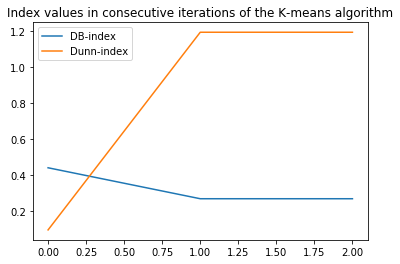

1.1916532768893362


In [5]:
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(3,X)
print(centroids)
#print(cluster_table)
print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

print(cost_values_dunn[-1])

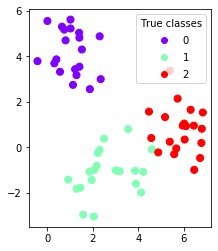

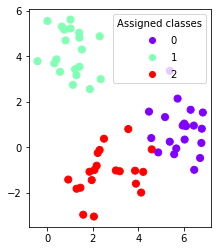

In [6]:
# Scatter plot - ORIGINAL
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=y, s=50 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True classes")
plt.show()

# Scatter plot - K-MEANS
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=cluster_table[:,1], s=50 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Assigned classes")
plt.show()

## Testing with the real benchmark data

## Testing with 2-dimensional data (Synthetic)

#### Reading in data

In [7]:
## Read in the data
synthetic = open("./Data/Synthetic.rtf").read()

## Transform the data into the format that our functions use

# Deleting the unnecessary parts of the text,
# which do not contain values
synthetic = synthetic[395:]
synthetic = synthetic.split("\\")

# Clean string values
synthetic = [w.replace('\n', '') for w in synthetic]
synthetic = [w.replace(' ', '') for w in synthetic]
synthetic = synthetic[:-1]

# Turn the strings into integer variables
synthetic_col1 = [int(w[:6]) for w in synthetic]
synthetic_col2 = [int(w[6:]) for w in synthetic]

# Check the length of the lists to see if method worked
print(len(synthetic_col1))
print(len(synthetic_col2))

# Convert the lists into numpy arrays and
synthetic = np.asarray((synthetic_col1,synthetic_col2))
synthetic = synthetic.T



print(synthetic.shape)
print(synthetic)

5000
5000
(5000, 2)
[[664159 550946]
 [665845 557965]
 [597173 575538]
 ...
 [650661 861267]
 [599647 858702]
 [684091 842566]]


### K-means method

#### Running the K-means algorithm

In [10]:
X = synthetic[:500,:]
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(15,X)

[320 154 407 278 216 212 401 160 292 320 138 351 169 396 159]


#### Calculating index values

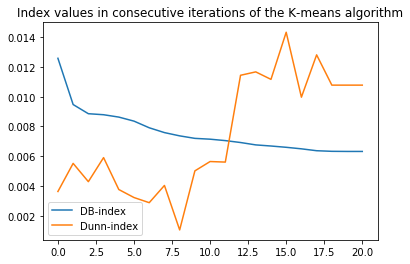

In [11]:
#print(centroids)
#print(cluster_table)
#print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

#print(cost_values_dunn[-1])

#### Visualizing the clusters

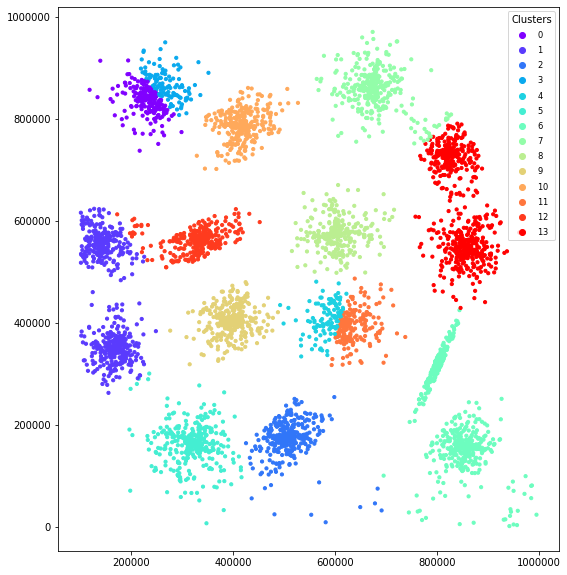

In [10]:
# Scatter plot - K-MEANS
fig,ax = plt.subplots(figsize=(10,10))
plt.axes().set_aspect('equal')

scatter=plt.scatter(X[:, 0], X[:, 1], c=cluster_table[:,1], s=10 , cmap='rainbow');

# Produce a legend with the unique colors for each cluster
legend1 = plt.legend(*scatter.legend_elements(),
                     fontsize = 'small',
                    loc="upper right", title="Clusters")


plt.show()

In [11]:
# Sanity-check for the clusters

c=cluster_table[:,1]
np.unique(c)
print(centroids)

[[230846.07692308 836407.11312217]
 [156483.19868637 445594.05418719]
 [510123.37325905 172619.72423398]
 [270086.10833333 868333.03333333]
 [582976.57391304 409861.39130435]
 [318982.28571429 161654.50857143]
 [830812.92835821 227755.2880597 ]
 [678312.47074468 857735.67287234]
 [606574.95622896 574455.16835017]
 [397649.17765043 404729.68194842]
 [417799.69426752 787001.99363057]
 [635769.59471366 393567.78414097]
 [330347.20402299 563014.93678161]
 [844050.32093023 628672.74263566]
 [            nan             nan]]


### Minimum Spanning Tree clustering

#### Running the Kruskal-algorithm

In [12]:
from datetime import datetime
X = synthetic
print(datetime.now())
#result = mst_cluster(X,k=15,d=2)
result = mst_cluster_UF(X, k=2)
print(datetime.now())

2019-11-26 23:28:46.817411
2019-11-26 23:32:16.238586


#### Calculating index values

In [13]:
mst_centroids = centroid_calc_for_mst(K=15,d=2,result=result,X=X)
print(mst_centroids)

[[634461.46424385 528696.28722157]
 [351221.49853801 794475.54824561]
 [199643.         791258.25      ]
 [851360.46688742 153151.13907285]
 [236648.35261708 532952.44903581]
 [415175.05028736 168139.96695402]
 [959374.94117647  41754.82352941]
 [718445.5         29514.5       ]
 [670785.          52625.33333333]
 [845016.           4671.        ]
 [567751.          15690.        ]
 [198355.          70290.        ]
 [695655.          99820.        ]
 [569075.          86609.        ]
 [347956.           6311.        ]]


In [14]:
## Calculate index values for MST
db_temp = DB_index(X,mst_centroids,result)
dunn_temp = dunn_index(X,mst_centroids,result)

print(db_temp)
print(dunn_temp)

0.002910106137691751
0.0002754827191215728


In [15]:
# Calculate index values for K-Means
print(cost_values_db[-1])
print(cost_values_dunn[-1])

nan
0.002289732174629303


#### Visualizing the clusters

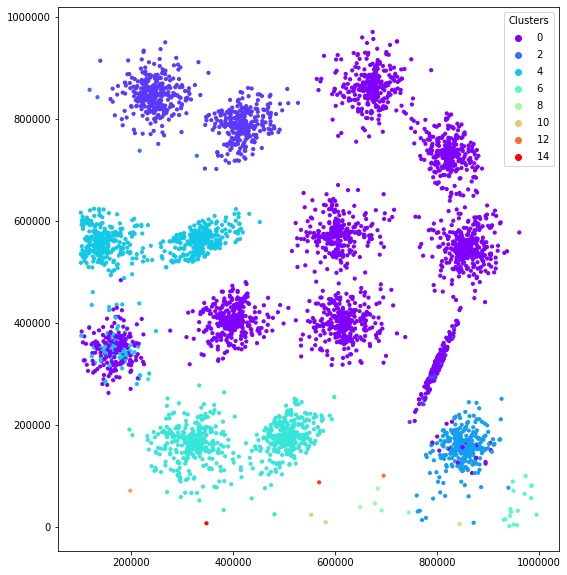

In [16]:
# Scatter plot - MST/Kruskal
fig,ax = plt.subplots(figsize=(10,10))
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=result[:,1], s=10 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.show()

### Comparing index values for K-means and MST

In [17]:
### Comparing index values

## K-means
# Calculate index values for K-Means
db_kmeans = cost_values_db[-1]
dunn_kmeans = cost_values_dunn[-1]

## MST
# Calculate index values for MST
db_mst = DB_index(X,centroids,result)
dunn_mst = dunn_index(X,centroids,result)

print("The DB-index for K-means is {} and for MST it is {}".format(db_kmeans,db_mst))
print("The Dunn-index for K-means is {} and for MST it is {}".format(dunn_kmeans,dunn_mst))

The DB-index for K-means is nan and for MST it is nan
The Dunn-index for K-means is 0.002289732174629303 and for MST it is 0.0002754827191215728


### Optimizing over K (number of hypothetical clusters)

In this section we check whether our functions can recover that for the Synthetic dataset 15 clusters is the best (best index values). IF this is true, we can have confidence that repeating the same procedure will help us to find the optimal, but a priori unknown number of clusters in the Thyroid dataset.

[173 214 168 390 241 459 493  61 253 270 347 296]
[ 24 373 233 475 259 395 400 497  56 221 414  82 171]
[ 89 281 240 475 495  18 472  88  34 290  91 463 433  28]
[219 416 377 341 367  51 489 100 241  48  91 237  69 131 122]
[485 153 495 148 228 142 285  48 482 416 257 146 430 215 174  10]


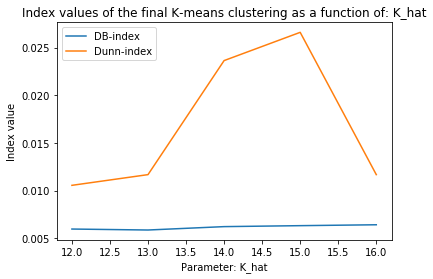

In [18]:
X1 = X[:500,:]
index_params_plotter('K_hat',12,17,X1)

## Testing with 5 dimensional data (Thyroid)

#### Reading in data

In [3]:
## Read in the data
thyroid = pd.read_csv('./Data/Thyroid_new.csv', header=None)
print(thyroid.head())
print(thyroid.shape)

         0        1        2        3        4
0  3195023  3455331  3497964  3068822  3206710
1  3651455  3412754  4131996  3248619  3603214
2  4716462  4051411  3638860  3150548  2946503
3  3347167  2433481  3075276  3150548  3058020
4  3042879  2859252  3004828  3166893  2859768
(215, 5)


### K-means method

In [4]:
X_5d = np.array(thyroid)

#### Running the k-means algorithm

In [20]:
X_5d = np.array(thyroid)
print(X_5d.shape)
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(3,X_5d)

(215, 5)
[ 67 141  86]


#### Optimizing over K (number of hypothetical clusters)

[100   7]
[ 56 137 109]
[128 195 104  17]
[169 185  21 178 143]
[196  52 188  93  75 115]
[ 81  20 179   7  66  81  95]
[ 69 163 194  34  34  40   3  96]
[139 163  52 167  23 170   9 161 121]


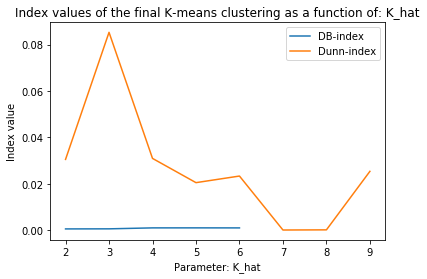

In [21]:
index_params_plotter(X = X_5d, param = 'K_hat',start_value = 2,end_value = 10)

#### Fitting the optimal model

In [22]:
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(3,X_5d)

[199  25 170]


#### Calculating the index values

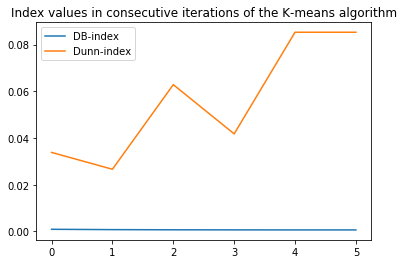

In [23]:
#print(centroids)
#print(cluster_table)
#print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

#print(cost_values_dunn[-1])

### Minimum Spanning Tree clustering

#### Running the Kruskal algorithm

In [8]:
#result_5d = mst_cluster(X_5d,k=3,d=5)
# Using the optimised number of clusters from k-means
result_5d = mst_cluster_UF(X_5d, k=3)


#### Optimizing over K (number of hypothetical clusters)

In [9]:
mst_index_params_plotter(param = 'K_hat',start_value = 2,end_value = 15,X=X_5d)

KeyboardInterrupt: 

Based on this analysis the optimal number of clusters is 2 or maybe 11, so MST finds a different optimum than K-means (which found 3 as the best number of clusters for MST.

#### Calculating the index values

In [10]:
mst_centroids_5d = centroid_calc_for_mst(K=3,d=5, result=result_5d, X=X_5d)
print(mst_centroids_5d)

## Calculate index values for MST
db_temp = DB_index(X_5d,mst_centroids_5d,result_5d)
dunn_temp = dunn_index(X_5d,mst_centroids_5d,result_5d)

print(db_temp)
print(dunn_temp)

[[ 3388238.39906103  3408656.6056338   3401387.48356808  3322133.55399061
   3373723.2629108 ]
 [ 4107886.          1475497.          2441244.         12140369.
   5548567.        ]
 [ 3575383.          1858691.          2441244.          9623219.
   5226406.        ]]
0.0001672803909053092
0.24070869611275858


### Comparing index values for K-means and MST

In [27]:
### Comparing index values

## K-means
# Calculate index values for K-Means
db_kmeans = cost_values_db[-1]
dunn_kmeans = cost_values_dunn[-1]

## MST
# Calculate index values for MST
db_mst = DB_index(X_5d,mst_centroids_5d,result_5d)
dunn_mst = dunn_index(X_5d,mst_centroids_5d,result_5d)

print("The DB-index for K-means is {} and for MST it is {}".format(db_kmeans,db_mst))
print("The Dunn-index for K-means is {} and for MST it is {}".format(dunn_kmeans,dunn_mst))

The DB-index for K-means is 0.0006236033901032015 and for MST it is 0.00029210163363716716
The Dunn-index for K-means is 0.08526102745007716 and for MST it is 0.07330747253597258


## WIP (Work in Progress)

In [ ]:
def index_params(n=300,p=2,K_true=3,std=0.9,K_hat=5):
    X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(K_hat,X)
    db_final = cost_values_db[-1]
    dunn_final = cost_values_dunn[-1]
    
    return db_final,dunn_final

In [ ]:

def index_params_plotter(param,start_value,end_value):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:
        #a = str(param)+'='+str(i)
        #print(type(a))
        temp_dict = {str(param) : i}
        #db_final,dunn_final = index_params(param=i)
        db_final,dunn_final = index_params(**temp_dict)
        # Use dictionary instead!!
        #db_final,dunn_final = index_params(K_hat=i)
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()

In [ ]:
index_params_plotter(param='K_hat',start_value=2,end_value=6) # Algorithm should find 3 as optimal

## Support

In [ ]:
# Test the custom function

x = np.array([1,2,3])
y = np.array([1,1,1])

print(euclidean_dist(x,y))

In [ ]:
# Quick and dirty check for finding the 2 closest points

points = np.random.rand(100,2)

print(len(points))
#print(points)

results = np.random.rand(1,3)

for i in range(0,len(points)):
    for j in range(i+1,len(points)):
        dist = np.linalg.norm(points[i,:]-points[j,:])
        temp = np.array([i,j,dist]).reshape(1,3)
        #print(temp.shape)
        #print(results.shape)
        results = np.vstack((results,temp))

results = results[1:,:]        
#print(results)
print(min(results[:,2]))
a = min(results[:,2])


results = pd.DataFrame(results)
results.columns = ['point_1','point_2','distance']
#print(results.columns)

# Get the closest point
print(results[results['distance']<=a])


# Plot histogram of distance
plt.hist(results['distance'])
plt.show()

# Distance-sorted array
sorted_results = results.sort_values(by=['distance'],ascending=False).reset_index()
print(sorted_results)
plt.plot(sorted_results['distance'])
plt.show()

In [ ]:
# Benchmark data generation
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=60, centers=5,n_features = 2,
                  random_state=0, cluster_std=0.2)

In [ ]:
X = pd.DataFrame(X)
print(X.shape[0])

In [ ]:
dist_matrix = np.zeros((len(y), len(y)))

In [ ]:
for i in range(0,len(y)):
    for j in range(i+1,len(y)):
        dist_matrix[i,j]=euclidean_dist(np.array(X.iloc[i,]),np.array(X.iloc[j,]))

In [ ]:
print(dist_matrix)

In [ ]:
temp = adjacency_matrix(X)
print(len(temp))

In [ ]:
temp_vector = edge_vector(temp)
print(len(temp_vector))
print(temp_vector[21,:])

In [ ]:
sorted_list = edge_sorting(temp_vector)
print(len(sorted_list))

In [ ]:
# Parameters
K = 5 # Number of clusters
n = X.shape[0] # Number of observations
d = X.shape[1] # dimensions
X = np.array(X) # Convert pandas dataframe to numpy array

# STEP 0
# Get initial starting points
initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
print(initial_indices)

centroids = np.zeros((K, d))

counter = 0
for i in initial_indices:
    centroids[counter,:] = X[i,:]
    counter += 1

print(centroids)

# STEP 1
# Assign points to centroids
cluster_table = np.zeros((n, 2))
cluster_table[:,0] = np.arange(0,n,1)
cluster_table = cluster_table.astype(int)

change_tracker = True
overall_change = 0
for i in range(0,n):
    current_cluster = int(cluster_table[i,1])
    #print(current_cluster)
    current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
    for j in range(0,K):
        temp = euclidean_dist(X[i,],centroids[j,])
        if temp<current_dist:
            cluster_table[i,1]=j
            current_dist = temp
            
            overall_change += 1
            
if overall_change == 0:
    change_tracker = False

# STEP 2
# Recalculate centroids
print(cluster_table)

# Filter observations
temp_table = cluster_table[cluster_table[:,1]==0]
print(temp_table)

for i in range(0,K):
    # Filter for points in the given cluster
    temp_table2 = cluster_table[cluster_table[:,1]==i]
    
    # Calculating new centroids
    temp_array = np.zeros((len(temp_table2),d))
    counter = 0
    
    for j in temp_table2[:,0]:
        temp_array[counter,:] = X[j,:]
        counter += 1
    
    # Assign the new centroids
    centroids[i,:] = np.mean(temp_array, axis=0)
    

print(centroids)
print(overall_change)

In [ ]:
def k_means_clustering(K,X):
    n = X.shape[0] # Number of observations
    d = X.shape[1] # dimensions
    X = np.array(X) # Convert pandas dataframe to numpy array

    # STEP 0
    # Get initial starting points
    initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
    print(initial_indices)

    centroids = np.zeros((K, d))

    counter = 0
    for i in initial_indices:
        centroids[counter,:] = X[i,:]
        counter += 1

    #print(centroids)

    # STEP 1
    # Assign points to centroids
    cluster_table = np.zeros((n, 2))
    cluster_table[:,0] = np.arange(0,n,1)
    cluster_table = cluster_table.astype(int)
    
    
    change_tracker = True
    
    # Big loop
    while change_tracker:
        overall_change = 0
        for i in range(0,n):
            current_cluster = int(cluster_table[i,1])
            #print(current_cluster)
            current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
            for j in range(0,K):
                temp = euclidean_dist(X[i,],centroids[j,])
                if temp<current_dist:
                    cluster_table[i,1]=j
                    current_dist = temp

                    overall_change += 1

        if overall_change == 0:
            change_tracker = False

        # STEP 2
        # Recalculate centroids
        #print(cluster_table)

        # Filter observations
        temp_table = cluster_table[cluster_table[:,1]==0]
        #print(temp_table)

        for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = cluster_table[cluster_table[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids
            centroids[i,:] = np.mean(temp_array, axis=0)
            
    return centroids, cluster_table
    

In [ ]:
# Distances
def within_cluster_dist(X,centroids,cluster_table):
    sums = []
    for i in range(0,len(centroids)):
        temp = cluster_table[cluster_table[:,1]==i]
        temp_sum = 0

        for j in range(0,len(temp)):
            index = temp[j,0]
            current_dist = euclidean_dist(X[index,],centroids[i,])
            temp_sum += current_dist

        temp_sum = math.sqrt(temp_sum/len(temp))

        sums.append(temp_sum)
        
    return sums

sums = within_cluster_dist(X,centroids,cluster_table)


print(sums)
        

In [ ]:
# Cluster separation
def cluster_separation(centroids):
    combinations = int(len(centroids)*(len(centroids)-1)/2)
    #print(combinations)
    separations = np.zeros((combinations,3))
    #print(separations)

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j
            separations[counter,2] = euclidean_dist(centroids[i,],centroids[j,])

            counter += 1
            
    return separations

separations = cluster_separation(centroids)
print(separations)

In [ ]:
def DB_index(X,centroids,cluster_table):
    sums = within_cluster_dist(X,centroids,cluster_table)
    separations = cluster_separation(centroids)


    r_s = separations.copy()
    for i in range(0, len(r_s)):
        index_1 = int(r_s[i,0])
        index_2 = int(r_s[i,1])
        r_s[i,2] = (sums[index_1]+sums[index_2])/separations[i,2]

    d = []
    for j in range(0,len(centroids)):

        if j==0:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            d.append(max1)
        elif j==len(centroids)-1:
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            d.append(max2)
        else:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            final_max = max(max1,max2)
            d.append(final_max)
            
    DB_index_val = sum(d)/len(centroids)
    
    return DB_index_val
    
#print(r_s[:,2])
index_val = DB_index(X,centroids,cluster_table)
print(DB_index(X,centroids,cluster_table))

In [ ]:
def max_within_distances(X,centroids,cluster_table):

    max_within_distances = []
    for k in range(0,len(centroids)):
        temp_table = cluster_table[cluster_table[:,1]==k]
        temp_max = 0
        for i in range(0,len(temp_table)):
            for j in range(i+1,len(temp_table)):
                index_1 = temp_table[i,0]
                index_2 = temp_table[j,0]
                current_value = euclidean_dist(X[index_1,],X[index_2,])
                if current_value>temp_max:
                    temp_max = current_value

        max_within_distances.append(temp_max)
        
    return max_within_distances

max_within_distances_temp = max_within_distances(X,centroids,cluster_table)


print(max_within_distances_temp)
            
    

In [ ]:
def min_between_distances(X,centroids,cluster_table):

    combinations = int(len(centroids)*(len(centroids)-1)/2)
    separations = np.zeros((combinations,3))

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j

            temp_table1 = cluster_table[cluster_table[:,1]==i]
            temp_table2 = cluster_table[cluster_table[:,1]==j]
            index_1 = temp_table1[1,0]
            index_2 = temp_table2[1,0]
            temp_min = euclidean_dist(X[index_1,],X[index_2,])
            for l in range(0,len(temp_table1)):
                for h in range(0,len(temp_table2)):
                    index_1 = temp_table1[l,0]
                    index_2 = temp_table2[h,0]
                    current_value = euclidean_dist(X[index_1,],X[index_2,])
                    if current_value<temp_min:
                        temp_min = current_value



            separations[counter,2] = temp_min

            counter += 1
            
    return separations

separations_temp = min_between_distances(X,centroids,cluster_table)    
print(separations_temp)

In [ ]:
def dunn_index(X,centroids,cluster_table):
    separations_temp = min_between_distances(X,centroids,cluster_table)
    max_within_distances_temp = max_within_distances(X,centroids,cluster_table)
    
    result = min(separations_temp[:,2])/max(max_within_distances_temp)
    
    return result

dunn_temp = dunn_index(X,centroids,cluster_table)
print(dunn_temp)

In [ ]:
#### NOT USED CURRENTLY!

# Assign the new centroids
K = 15
d = 2

#points_set['Cluster'].nunique()
uniques = pd.DataFrame(result).iloc[:,1]
uniques = uniques.unique()
print(uniques)

# Get where the current cluster value is
index = int(result[0,1])
index = 274
#index = uniques[index]
unique_places = np.array([i==index for i in uniques])
temp = np.where(unique_places)[0]
print(temp)

indexer = 0

# Loop over the clusters table and assign cluster names
# going from 0-15 (basically just renaming clusters for convenience)
for i in range(0,len(result)):
    # Getting the current cluster label
    index = int(result[i,1]) 
    # Searching the current cluster label in the list of unique labels
    unique_places = np.array([i==index for i in uniques])
    
    # Assign the relative location of the current label to the range of 0-15
    temp = np.where(unique_places)[0]
    result[i,1] = temp

# Initialize the centroids to be 0
centroids2 = np.zeros((K, d))

for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = result[result[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids - coordinate-wise mean of points in the cluster
            centroids2[i,:] = np.mean(temp_array, axis=0)
            
#print(centroids2)


def centroid_calc_for_mst(K,d,result,X):
    """Calculates the centroids of the clusters
    found by the MST method"""
    
    # Get current unique labels
    uniques = pd.DataFrame(result).iloc[:,1]
    uniques = uniques.unique()
    
    # Loop over the clusters table and assign cluster names
    # going from 0-15 (basically just renaming clusters for convenience)
    for i in range(0,len(result)):
        # Getting the current cluster label
        index = int(result[i,1]) 
        # Searching the current cluster label in the list of unique labels
        unique_places = np.array([i==index for i in uniques])

        # Assign the relative location of the current label to the range of 0-15
        temp = np.where(unique_places)[0]
        result[i,1] = temp

    # Initialize the centroids to be 0
    centroids2 = np.zeros((K, d))

    for i in range(0,K):
                # Filter for points in the given cluster
                temp_table2 = result[result[:,1]==i]

                # Calculating new centroids
                temp_array = np.zeros((len(temp_table2),d))
                counter = 0

                for j in temp_table2[:,0]:
                    temp_array[counter,:] = X[j,:]
                    counter += 1

                # Assign the new centroids - coordinate-wise mean of points in the cluster
                centroids2[i,:] = np.mean(temp_array, axis=0)

    return centroids2


mst_centroids = centroid_calc_for_mst(K,d,result,X)
print(mst_centroids)